In [1]:
%cd ..

/home/pg/projects/tennis-predictor


/home/pg/projects/tennis-predictor/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from tennis_predictor.models.predict import preprocess
from tennis_predictor.config.data import TRAIN_AUGMENTED_PATH, DEV_PATH, TEST_PATH
from tennis_predictor.config.columns import FEATURES, Y

## Load data

In [3]:
df_train = pd.read_csv(TRAIN_AUGMENTED_PATH)
df_dev = pd.read_csv(DEV_PATH)
df_train.head()

/tmp/ipykernel_102600/2046438266.py:1: DtypeWarning: Columns (15,16,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(TRAIN_AUGMENTED_PATH)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,...,hand_diff,rank_diff,points_diff,elo_diff,elo_surface_diff,age_diff,home_diff,elo_prob,elo_surface_prob,P1_wins
0,28.0,Hamburg,Hamburg TMS,2008-05-15,Masters,Outdoor,Clay,3rd Round,3.0,Safin M.,...,0,77.0,-960.0,-38.285773,-341.915616,-3.416838,0,0.445124,0.122580,0
1,29.0,Hamburg,Hamburg TMS,2007-05-14,Masters,Outdoor,Clay,1st Round,3.0,Almagro N.,...,0,-727.0,684.0,118.979546,-361.556846,-6.806297,0,0.664832,0.110929,1
2,16.0,Acapulco,Abierto Mexicano,2017-03-02,ATP500,Outdoor,Hard,2nd Round,3.0,Nadal R.,...,1,-32.0,3063.0,379.184520,413.103611,-4.465435,0,0.898691,0.915135,1
3,5.0,Sydney,Medibank International,2008-01-09,International,Outdoor,Hard,2nd Round,3.0,Calleri A.,...,0,22.0,-850.0,-90.396450,125.121663,-0.049281,0,0.372767,0.672664,1
4,36.0,Halle,Gerry Weber Open,2016-06-13,ATP500,Outdoor,Grass,1st Round,3.0,Nishikori K.,...,0,-23.0,2979.0,312.804363,0.000000,4.153320,0,0.858228,0.500000,1


In [4]:
X_train = preprocess(df_train)
X_dev = preprocess(df_dev)
y_train = df_train[Y]
y_dev = df_dev[Y]

/home/pg/projects/tennis-predictor/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [5]:
X_train.head()

,Best of_5.0,Best of_nan,Court_Outdoor,P1_age,P1_elo,P1_elo_surface,P1_hand_L,P1_hand_R,P1_hand_U,P1_home,...,WTA,age_diff,elo_diff,elo_prob,elo_surface_diff,elo_surface_prob,hand_diff,home_diff,points_diff,rank_diff
0,0.0,0.0,1.0,28.298426,2201.187429,1379.796441,0.0,1.0,0.0,0,...,30.0,-3.416838,-38.285773,0.445124,-341.915616,0.122580,0,0,-960.0,77.0
1,0.0,0.0,1.0,21.727584,2181.390572,1510.223131,0.0,1.0,0.0,0,...,30.0,-6.806297,118.979546,0.664832,-361.556846,0.110929,0,0,684.0,-727.0
2,0.0,0.0,1.0,30.746064,2596.826096,1960.178688,1.0,0.0,0.0,0,...,30.0,-4.465435,379.184520,0.898691,413.103611,0.915135,1,0,3063.0,-32.0
3,0.0,0.0,1.0,31.318275,2186.504794,1614.785431,0.0,1.0,0.0,0,...,30.0,-0.049281,-90.396450,0.372767,125.121663,0.672664,0,0,-850.0,22.0
4,0.0,0.0,1.0,26.455852,2602.848605,1500.000000,0.0,1.0,0.0,0,...,30.0,4.153320,312.804363,0.858228,0.000000,0.500000,0,0,2979.0,-23.0


# Hyperparameter optimization

## Bayesian optimization

In [ ]:
# Define the search space for hyperparameters
search_space = [
    Real(0, 100, name='alpha'),
    Real(0.5, 1.0, name='colsample_bytree'),
    Real(0.0, 0.2, name='gamma'),
    Real(0, 100.0, name='lambda'),
    Integer(4, 6, name='max_depth'),
    Integer(70, 150, name='n_estimators'),
    Real(0.5, 1.0, name='subsample')
]

# Define the objective function to minimize
@use_named_args(search_space)
def objective(**params):
    model = xgb.XGBClassifier(eval_metric='logloss', **params)
    model.fit(X_train, y_train)
    y_train_proba = model.predict_proba(X_train)
    train_logloss = log_loss(y_train, y_train_proba, labels=[0, 1])
    y_dev_proba = model.predict_proba(X_dev)
    dev_logloss = log_loss(y_dev, y_dev_proba, labels=[0, 1])
    return max(train_logloss, dev_logloss)  # Reduce overfitting on dev dataset

# Perform Bayesian optimization
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=200,  # Number of iterations
    n_initial_points=30,  # Number of initial random points
    random_state=42, # For reproducibility
    n_jobs=-1,  # Use all available cores
)

# Print the best hyperparameters and corresponding log loss
print("Best hyperparameters:", result.x)
print("Best log loss:", result.fun)

# Train the model with the best hyperparameters
best_params = dict(zip([dim.name for dim in search_space], result.x))
xgb_model = xgb.XGBClassifier(eval_metric='logloss', **best_params)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_proba = xgb_model.predict_proba(X_dev)
print("Log loss on X_dev with optimized hyperparameters:", log_loss(y_dev, y_proba, labels=[0, 1]))

Best hyperparameters: [13.175989846142963, 0.5962301022296196, 0.07854468542709277, 26.558917737061588, np.int64(4), np.int64(70), 0.736769544586602]
Best log loss: 0.5367389508421361
Log loss on X_dev with optimized hyperparameters: 0.5367389508421361


## Hyperparameter impact

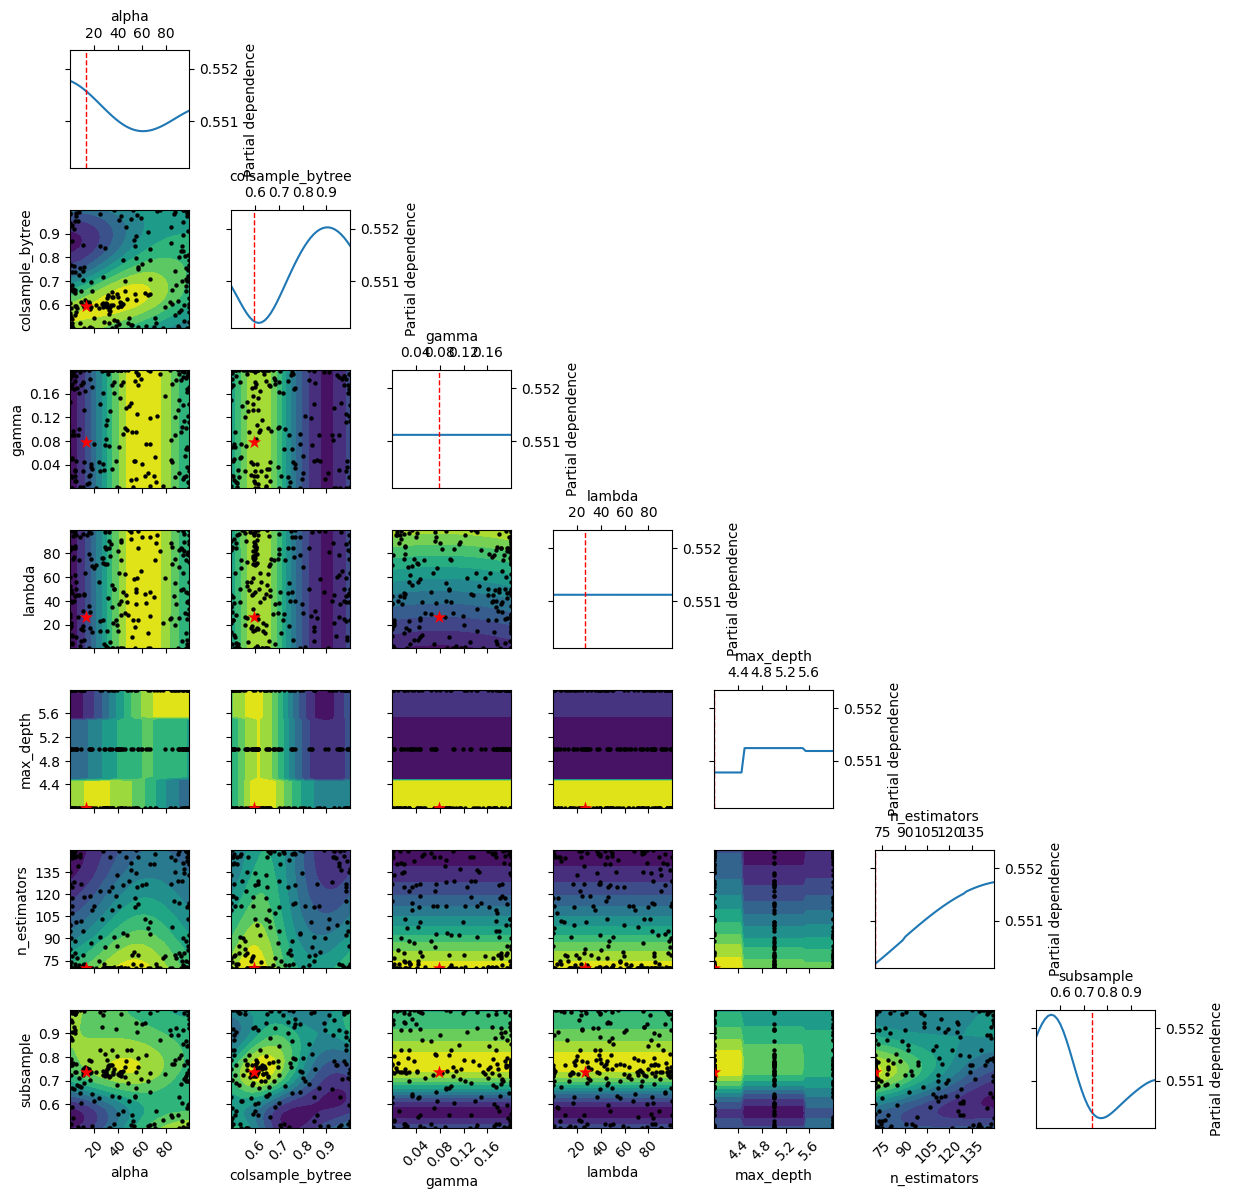

In [ ]:
plot_objective(result)
plt.savefig('./reports/figures/hyperparameter_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
# model = GridSearchCV(
#     xgb.XGBClassifier(),
#     {
#         'max_depth': [3, 4, 5],
#         'n_estimators': [60, 80, 100],
#         'subsample': [0.8, 1.0],
#         'colsample_bytree': [0.8, 1.0],
#         'gamma': [0, 0.2, 1],
#         'lambda': [0, 0.2, 1],
#         'alpha': [0, 0.2, 1],
#     },
#     cv=3,
#     scoring='neg_log_loss',
#     n_jobs=-1
# )

# model.fit(X_train, y_train)
# print(model.best_params_)
# print(model.best_score_)

# Model

In [6]:
# Define the XGBoost model
BEST_HYPER_PARAMETERS = {
    "alpha": 13.175989846142963,
    "colsample_bytree": 0.5962301022296196,
    "gamma": 0.07854468542709277,
    "lambda": 26.558917737061588,
    "max_depth": np.int64(4),
    "n_estimators": np.int64(70),
    "subsample": 0.736769544586602,
}

xgb_model = xgb.XGBClassifier(eval_metric='logloss', **BEST_HYPER_PARAMETERS)

# Train the model
xgb_model.fit(X_train, y_train)

y_proba = xgb_model.predict_proba(X_train)
print(log_loss(y_train, y_proba, labels=[0, 1]))

y_proba = xgb_model.predict_proba(X_dev)
print(log_loss(y_dev, y_proba, labels=[0, 1]))

0.5343262242295221
0.5367389508421361


## Feature importance

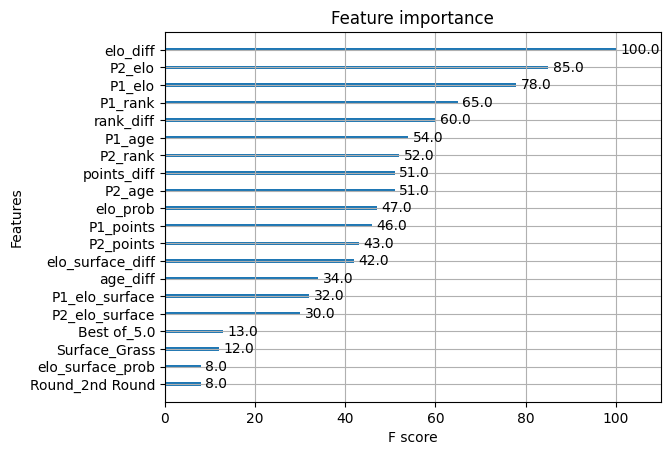

In [7]:

plot_importance(xgb_model, importance_type='weight', max_num_features=20)
plt.savefig('./reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluation

In [ ]:
from tennis_predictor.config.data import TEST_EVALUATION_PATH

In [28]:
df = pd.read_csv(TEST_EVALUATION_PATH)
df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,...,elo_surface_prob,P1_wins,P1_wins_prediction,P1_estimated_winrate,P2_estimated_winrate,P1_kelly,P2_kelly,bets,capitals,growth
0,1.0,Brisbane,Brisbane International,2024-01-02,ATP250,Outdoor,Hard,1st Round,3.0,Hanfmann Y.,...,0.851945,1,0,0.151959,0.848041,-0.116409,0.157320,-0.157320,0.842680,1.000000
1,1.0,Brisbane,Brisbane International,2024-01-02,ATP250,Outdoor,Hard,1st Round,3.0,Duckworth J.,...,0.500000,1,0,0.247904,0.752096,-0.358624,0.358596,-0.302182,0.540498,0.641404
2,1.0,Brisbane,Brisbane International,2024-01-02,ATP250,Outdoor,Hard,1st Round,3.0,Altmaier D.,...,0.896533,1,1,0.803181,0.196819,0.469588,-0.411651,0.253811,0.690247,1.277057
3,1.0,Brisbane,Brisbane International,2024-01-02,ATP250,Outdoor,Hard,1st Round,3.0,Kubler J.,...,0.786062,1,1,0.643207,0.356793,0.417389,-0.955875,0.288102,1.145447,1.659475
4,1.0,Brisbane,Brisbane International,2024-01-02,ATP250,Outdoor,Hard,1st Round,3.0,Arnaldi M.,...,0.808360,1,1,0.706884,0.293116,0.349426,-0.428195,0.400249,1.473651,1.286529


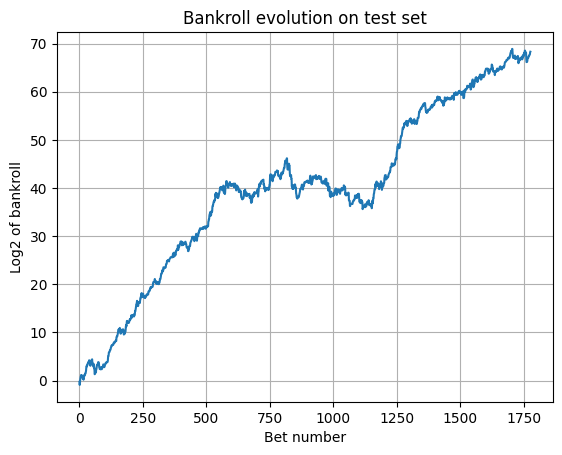

In [25]:
np.log2(df['capitals'], ).plot()
plt.xlabel('Bet number')
plt.ylabel('Log2 of bankroll')
plt.title('Bankroll evolution on test set')
plt.grid(True)
plt.savefig('./reports/figures/bankroll.png', dpi=300, bbox_inches='tight')
plt.show()

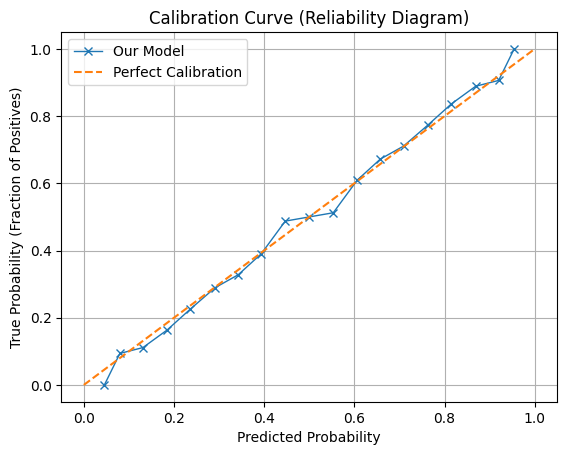

In [24]:
prob_true, prob_pred = calibration_curve(
    pd.concat([df["P1_wins"], df["P1_wins"] - 1]),
    pd.concat([df["P1_estimated_winrate"], 1 - df["P1_estimated_winrate"]]),
    n_bins=19,
    pos_label=1,
)

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='x', linewidth=1, label='Our Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability (Fraction of Positives)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.savefig('./reports/figures/calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()